In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle


import math
import os.path as path
import random
import shutil


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score

# 랜덤 시드 고정 
np.random.seed(22)



##  분포 확인

In [3]:
# 데이터 분포 확인하기 
# csv 파일 가져오기 
df = pd.read_csv("dataset/creditcard.csv", delimiter=',', dtype=np.float32)

# row 284807, col 31
print(df.shape)

distribution = pd.DataFrame( {"min": [ df[col].min() for col in df.columns],   # 최소값
                            "max": [ df[col].max() for col in df.columns],     # 최대값
                            "mean": [ df[col].mean() for col in df.columns],   # 평균값
                            "std": [ df[col].std() for col in df.columns],     # 표준 편차
                            "vars": [ df[col].var() for col in df.columns],    # 분산
                            "median": [ df[col].median() for col in df.columns],    # 중앙값
                            #"mode": [ df[col].mode(dropna=False) for col in df.columns],    # 최빈값
                            "minus_cnt" : [ len(list(filter(lambda x : x < 0 , df[col]))) for col in df.columns], # 음수 개수
                            "plus_cnt" : [ len(list(filter(lambda x : x > 0. , df[col]))) for col in df.columns], # 양수 개수
                            "zero_cnt" : [ len(list(filter(lambda x : x == 0. , df[col]))) for col in df.columns] # 0 개수
                            },
    index=[df.columns],
)
print(distribution)

(284807, 31)
               min            max          mean           std          vars  \
Time      0.000000  172792.000000  9.481387e+04  47488.144531  2.255124e+09   
V1      -56.407509       2.454930  1.339397e-08      1.958696  3.836489e+00   
V2      -72.715729      22.057730  0.000000e+00      1.651309  2.726820e+00   
V3      -48.325588       9.382559 -4.800400e-08      1.516255  2.299029e+00   
V4       -5.683171      16.875343  6.643411e-09      1.415869  2.004684e+00   
V5     -113.743309      34.801666  2.657364e-08      1.380247  1.905081e+00   
V6      -26.160505      73.301628 -1.500125e-09      1.332271  1.774946e+00   
V7      -43.557243     120.589493 -1.071518e-09      1.237094  1.530401e+00   
V8      -73.216721      20.007208 -1.071518e-10      1.194353  1.426479e+00   
V9      -13.434067      15.594995 -3.214554e-10      1.098632  1.206993e+00   
V10     -24.588263      23.745136 -4.071768e-09      1.088850  1.185594e+00   
V11      -4.797473      12.018913  7.71

## 전처리

In [3]:
# creditcard.csv 를 training set / test set (혹은 training set/ validation set/ test set ) 으로 분리하는 전처리 클래스
# 랜덤으로 나눠주는 유틸함수는 있는데, 나눌때 이상거래 비율을 맞춰서 나누는 유틸 함수는 찾지못해서 직접 구현 
# 이런 기능이 tensorflow에 있는지 모르겠음
class Preprocessing:

    def __init__(self, early_stopping=False):
        # 여러 실험해서 좋은 점수를 내는 모델을 찾아야 하므로  
        # training set / validation set / test set등은 딱한번 구해서 파일로 저장하고 고정해서 사용 
        if not path.isfile("dataset/train_set.csv") :
            self.save_dividing_sample_csv(srcpath="dataset/creditcard.csv", 
                                          trainpath="dataset/train_set.csv",
                                          samplepath="dataset/test_set.csv",
                                          sample_ratio=0.3)
                    
        if early_stopping and not path.isfile("dataset/early_stopping/train_set.csv") :
                
            self.save_dividing_sample_csv(srcpath="dataset/train_set.csv", 
                                          trainpath="dataset/early_stopping/train_set.csv",
                                          samplepath="dataset/early_stopping/validation_set.csv",
                                          sample_ratio=0.3)
            
            shutil.copyfile("dataset/test_set.csv", "dataset/early_stopping/test_set.csv")


    def save_dividing_sample_csv(self, srcpath, trainpath, samplepath, sample_ratio):
        # csv 파일 가져오기 
        df = pd.read_csv(srcpath, delimiter=',', dtype=np.float32)
        if "Time" in df.columns:
            df.drop(columns = "Time", inplace=True)
        
        train_data, sample_data = self.divide_sample(df, sample_ratio)
        
        train_data.to_csv(trainpath, sep=",", encoding='utf-8')
        sample_data.to_csv(samplepath, sep=",", encoding='utf-8')
        
    def divide_sample(self, df, dividing_ratio):
        #전체 데이터에서 sample과 training set 나눠서 리턴 
        
        # 훈련데이터 / 테스트 데이터는 동일 분포를 가지는게 좋다고함
        # 동일 분포를 가지게 하는거는 잘 모르겠고 이상거래 비율 정도만 맞춰서 샘플링 
        sample_len = math.ceil(len(df.values) * dividing_ratio) # dividing_ratio 따른 샘플 개수 구하기 
        fraud_ratio = df["Class"].value_counts()[1] / df["Class"].value_counts()[0] # 정상대비 이상거래 비율 계산 
        fraud_len = round(sample_len * fraud_ratio) # 샘플 개수 / 이상거래 비율 따른 이상거래 개수 구하기  
    
        fraud = df.loc[df["Class"] == 1]
        normal = df.loc[df["Class"] == 0]
    
        # 현재 이상거래 비율(0.00017) 만큼 인덱스 랜덤 선택/ 나머지는 정상거래 인덱스 랜덤 선택 
        sample_fraud_idx = np.random.choice(fraud.index.tolist(), size=fraud_len, replace=False, p=None)
        sample_normal_idx = np.random.choice(normal.index.tolist(), size=sample_len-fraud_len, replace=False, p=None)
        sample_idx = shuffle(np.concatenate((sample_fraud_idx, sample_normal_idx))) # 추출 인덱스 섞기 
    
        # 인덱스로부터 dataframe 구하기
        sample_data = pd.concat([df.iloc[[idx]] for idx in sample_idx]).reset_index()
        train_data = pd.concat([df.iloc[[idx]] for idx in df.index.tolist() if idx not in sample_idx]).reset_index()
    
        return train_data, sample_data 


    def load_data(self, fpath):
        #file path csv 읽어서 output 데이터 , input 데이터 나눠서 리턴
    
        data = pd.read_csv(fpath, delimiter=',', dtype=np.float32)
        
        x_data = np.array(data.iloc[:,0:-1].values, dtype=np.float32) # input 컬럼들 추출
        y_data = np.array(data.iloc[:,[-1]].values, dtype=np.float32) # output(class) 컬럼 추출
    
        return x_data, y_data
    


## 기본 
Normalization + Dropout 만 추가하여 테스트 

In [6]:
pr = Preprocessing()
x_train, y_train = pr.load_data("dataset/train_set.csv")
x_test, y_test = pr.load_data("dataset/test_set.csv")

# Normalization
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test) # test set도 normalization해야하는지?? 

# 기본 
# Model Build
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(29, activation = 'relu'), # 입력층
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(15, activation = 'relu'), # 은닉층 (필요한가??)
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 출력층
])

# Hyper-parameter tunning (optmizer, cost function)
learning_rate = 0.008
batch_size = 4096 # 2^12, 그래픽카드가 없어 gpu 활용은 힘듬. 대신 batch size 세팅을 했더니 속도가 많이 개선됨
epoch= 100


# ndarray -> dataset 변환 후 batch size세팅
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size) # buffer size?? 


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss = 'binary_crossentropy',
              metrics=[ tf.keras.metrics.F1Score(), tf.keras.metrics.Recall()]) # 비대칭 데이터 이고 이상거래 탐지가 핵심이므로  recall 수치 필요 

# Training
try:
    history = model.fit(dataset, epochs=epoch)
except Exception as e: 
    print(e)
    raise e


Epoch 1/100
49/49 [==============================] - 1s 10ms/step - loss: 0.0873 - f1_score: 0.0034 - recall: 0.0436
Epoch 2/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0185 - f1_score: 0.0034 - recall: 0.0000e+00
Epoch 3/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0152 - f1_score: 0.0034 - recall: 0.0000e+00
Epoch 4/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0144 - f1_score: 0.0034 - recall: 0.0000e+00
Epoch 5/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0138 - f1_score: 0.0034 - recall: 0.0000e+00
Epoch 6/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0130 - f1_score: 0.0034 - recall: 0.0000e+00
Epoch 7/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0125 - f1_score: 0.0034 - recall: 0.0000e+00
Epoch 8/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0118 - f1_score: 0.0034 - recall: 0.0000e+00
Epoch 9/100
49/49 [=====================

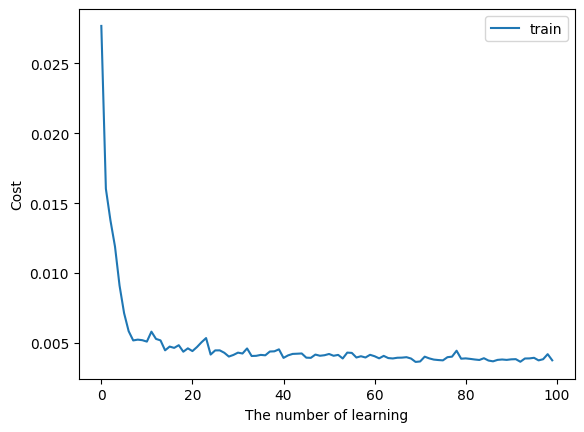

2671/2671 - 2s - loss: 0.0030 - f1_score: 0.0035 - recall: 0.8108 - 2s/epoch - 770us/step
f1_score: [0.00345904], recall: 0.8108108043670654


In [9]:

# Visualization
plt.plot(history.history['loss'], label='train')
plt.xlabel("The number of learning")
plt.ylabel("Cost")
plt.legend()
plt.show()

# Evaluation
loss, f1_score, recall = model.evaluate(x_test, y_test, verbose=2)
print(f"f1_score: {f1_score}, recall: {recall}")


#print("Accuracy = ", accuracy_score(predicted_x, y_data))
#print("Report = \n", classification_report(predicted_x, y_data))

recall이 0.8, f1 score가 0.0030

## 개선시도 1: Early Stopping
배운 것  모두 다 넣어서 테스트 
- dropout
- standard scaler
- batch normalization 
- weight initialization 
- early stopping with patience
- learning rate decay

은닉층 없애보기

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

    
# early stopping 을 위한 validation set 추가
pr = Preprocessing(early_stopping=True)
x_train, y_train = pr.load_data("dataset/early_stopping/train_set.csv")
x_validation, y_validation = pr.load_data("dataset/early_stopping/validation_set.csv")
x_test, y_test = pr.load_data("dataset/early_stopping/test_set.csv")

# Normalization 방법 바꿈. - standard scaler 이용 - data imbalance에 좋다고함. 원리는 모름 
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_validation = scaler.fit_transform(x_validation)
x_test = scaler.fit_transform(x_test)

# Model Build
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(29, activation = 'relu', kernel_initializer='he_uniform'), # 입력층 에 kaiming weight initialization 추가 
    tf.keras.layers.Dropout(0.2),                                                    # dropout 으로 랜덤으로 신경망 끄기
    #tf.keras.layers.BatchNormalization(synchronized=True),  
    tf.keras.layers.Dense(15, activation = 'relu', kernel_initializer='he_uniform'), # 은닉층 (필요한가 ??)에 kaiming weight initialization 추가 
    tf.keras.layers.Dropout(0.2),                                                    # dropout 으로 랜덤으로 신경망 끄기  
    #tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dense(1, activation='sigmoid')                                   # 출력층
])

# Hyper-parameter tunning (optmizer, cost function)
batch_size = 4096   # 2^12, 그래픽카드가 없어 gpu 활용은 힘듬. 대신 batch size 세팅을 했더니 속도가 많이 개선됨
epoch= 1000         # epoch이 커야 earlystopping 관련 확인을 제대로 할 수 있을 것 같아 1000으로 세팅

# learning rate decay 관련 
warmup_epoch = int(epoch * 0.1)
init_lr = 0.1
min_lr = 1e-6
power = 1.

# early stopping patience 개수 지정
patience = 50


# ndarray -> dataset 변환 후 batch size세팅
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size) # buffer size?? 

# learning rate decay with warmup : 0.1~ 1e-6 까지 learning rate 조정되도록 세팅 
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = init_lr,
    decay_steps = epoch - warmup_epoch,
    end_learning_rate = min_lr,
    power = power
)

model.compile(optimizer=tf.keras.optimizers.Adam(lr_scheduler),
              loss = 'binary_crossentropy',
              metrics=[ tf.keras.metrics.F1Score(), tf.keras.metrics.Recall()])  # 비대칭 데이터 이고 이상거래 탐지가 핵심이므로  recall 수치 필요 


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience) # with 40 patience

# Training
try:
    history = model.fit(dataset, validation_data=(x_validation, y_validation),  epochs=epoch,  callbacks=[es])
except Exception as e: 
    print(e)
    raise e



Epoch 1/1000
35/35 [==============================] - 3s 61ms/step - loss: 0.0429 - f1_score: 0.0127 - recall_4: 0.0083 - val_loss: 0.0105 - val_f1_score: 0.0176 - val_recall_4: 0.0000e+00
Epoch 2/1000
35/35 [==============================] - 2s 53ms/step - loss: 0.0166 - f1_score: 0.0119 - recall_4: 0.0000e+00 - val_loss: 0.0129 - val_f1_score: 0.0544 - val_recall_4: 0.0000e+00
Epoch 3/1000
35/35 [==============================] - 2s 51ms/step - loss: 0.0089 - f1_score: 0.0166 - recall_4: 0.0000e+00 - val_loss: 0.0063 - val_f1_score: 0.0098 - val_recall_4: 0.0000e+00
Epoch 4/1000
35/35 [==============================] - 2s 57ms/step - loss: 0.0075 - f1_score: 0.0091 - recall_4: 0.0000e+00 - val_loss: 0.0056 - val_f1_score: 0.0075 - val_recall_4: 0.0000e+00
Epoch 5/1000
35/35 [==============================] - 2s 58ms/step - loss: 0.0053 - f1_score: 0.0084 - recall_4: 0.0000e+00 - val_loss: 0.0054 - val_f1_score: 0.0078 - val_recall_4: 0.0000e+00
Epoch 6/1000
35/35 [===================

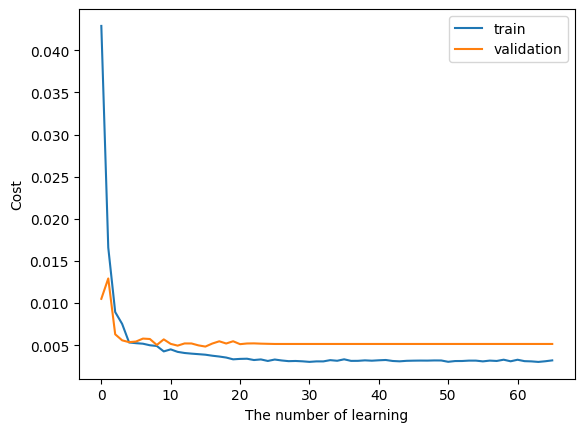

In [13]:

# Evaluation
train_loss, train_f1, train_recall = model.evaluate(x_train, y_train, verbose=0)
#validation_loss, validation_f1, validation_recall = model.evaluate(x_validation, y_validation, verbose=0)
#test_loss, test_f1, test_recall = model.evaluate(x_test, y_test, verbose=0)

#print(f"Train f1 score: {train_f1}, Test f1 score: {test_f1}")
#print(f"Train recall: {train_recall}, Test recall: {test_recall}")

# Visualization
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel("The number of learning")
plt.ylabel("Cost")
plt.legend()
plt.show()

# Evaluation
#loss, f1_score, recall = model.evaluate(x_test, y_test, verbose=2)
#print(f"f1_score: {f1_score}, recall: {recall}")

성능 안좋음

## 개선시도2: Regularization
배운 것  모두 다 넣어서 테스트 
- dropout
- standard scaler
- batch normalization
- weight initialization 
- l2 regularizer 추가 
- learning rate decay

In [12]:
pr = Preprocessing()
x_train, y_train = pr.load_data("dataset/train_set.csv")
x_test, y_test = pr.load_data("dataset/test_set.csv")

# Normalization 방법 바꿈. - standard scaler 이용 - data imvalance에 좋다고함. 원리는 모름
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

# Model Build
# regularizer 추가
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(
        29,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        kernel_initializer='he_uniform'),
    # 입력층 에 kaiming weight initialization 추가
    # dropout 으로 랜덤으로 신경망 끄기
    tf.keras.layers.Dropout(0.2),
    # batch normalization으로 중간중간 정규화
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dense(
        15,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        kernel_initializer='he_uniform'),
    # 은닉층 (필요한가 ??)에 kaiming weight initialization 추가
    # dropout 으로 랜덤으로 신경망 끄기
    tf.keras.layers.Dropout(0.2),
    # batch normalization으로 중간중간 정규화
    tf.keras.layers.BatchNormalization(synchronized=True),
    # 출력층
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Hyper-parameter tunning (optmizer, cost function)
learning_rate = 0.008
batch_size = 4096   # 2^12, 그래픽카드가 없어 gpu 활용은 힘듬. 대신 batch size 세팅을 했더니 속도가 많이 개선됨
epoch = 100

# learning rate decay 관련
warmup_epoch = int(epoch * 0.1)
init_lr = 0.1
min_lr = 1e-6
power = 1.

# ndarray -> dataset 변환 후 batch size세팅
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)  # buffer size??

# learning rate decay with warmup : 0.1~ 1e-6 까지 learning rate 조정되도록 세팅
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=init_lr,
    decay_steps=epoch - warmup_epoch,
    end_learning_rate=min_lr,
    power=power
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_scheduler),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.F1Score(),
         tf.keras.metrics.Recall()])  # 비대칭 데이터 이고 이상거래 탐지가 핵심이므로  recall 수치 필요

# Training
try:
    history = model.fit(dataset, epochs=epoch)
except Exception as e:
    print(e)
    raise e



Epoch 1/100
49/49 [==============================] - 2s 10ms/step - loss: 0.1498 - f1_score: 0.0034 - recall_1: 0.4506
Epoch 2/100
49/49 [==============================] - 1s 10ms/step - loss: 0.0201 - f1_score: 0.0034 - recall_1: 0.3924
Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0102 - f1_score: 0.0034 - recall_1: 0.4709
Epoch 4/100
49/49 [==============================] - 1s 10ms/step - loss: 0.0098 - f1_score: 0.0034 - recall_1: 0.4767
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0104 - f1_score: 0.0034 - recall_1: 0.4738
Epoch 6/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0097 - f1_score: 0.0034 - recall_1: 0.5000
Epoch 7/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0101 - f1_score: 0.0034 - recall_1: 0.4797
Epoch 8/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0101 - f1_score: 0.0034 - recall_1: 0.4797
Epoch 9/100
49/49 [==============================] -

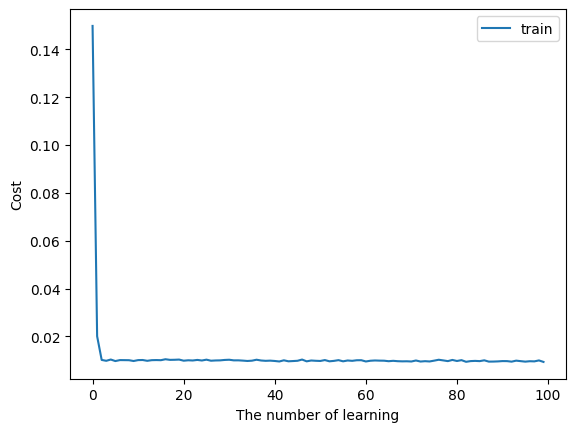

2671/2671 - 2s - loss: 0.0089 - f1_score: 0.0035 - recall_1: 0.6081 - 2s/epoch - 789us/step
f1_score: [0.00345831], recall: 0.6081081032752991


In [13]:

# Visualization
plt.plot(history.history['loss'], label='train')
plt.xlabel("The number of learning")
plt.ylabel("Cost")
plt.legend()
plt.show()

# Evaluation
loss, f1_score, recall = model.evaluate(x_test, y_test, verbose=2)
print(f"f1_score: {f1_score}, recall: {recall}")

더 안좋음 ...